# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    
    transform = transforms.Compose([transforms.Resize(image_size), 
                                    transforms.ToTensor()])
    
    dataSet = datasets.ImageFolder(data_dir, transform)
    
    dataLoader = torch.utils.data.DataLoader(dataset=dataSet, 
                                             shuffle=True,                                              
                                             batch_size=batch_size, 
                                             num_workers=0,
                                             )
    
    return dataLoader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

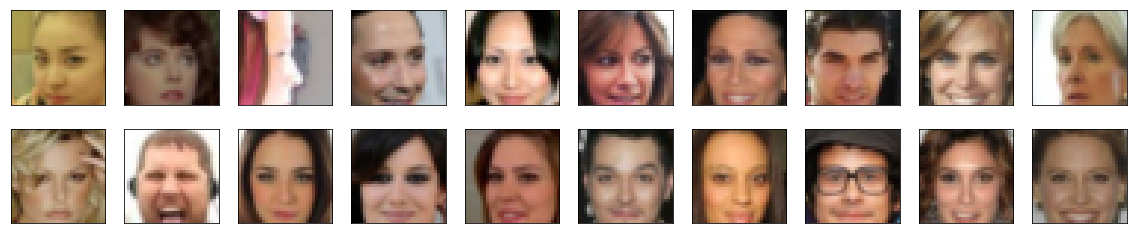

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    
    x = x*(max - min) + min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8745)
Max:  tensor(0.7961)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Helper function
#def ConvLayer(inputChannels, outputChannels, kernelSize, stride=2, padding=1, batchNorm=True):
def ConvLayer(inputChannels, outputChannels, kernelSize, stride=2, padding=1, norm=True, normType='BatchNorm'):
    '''
    Creates a convolutional layer and add optionally a batch normalization layer
    '''
    
    layers = []
    
    convlayer = nn.Conv2d(in_channels = inputChannels ,
                          out_channels = outputChannels, 
                          kernel_size = kernelSize, 
                          padding = padding, 
                          stride = stride,
                          bias = False)
    
    layers.append(convlayer)
    
    if norm:
        if normType == 'BatchNorm':
            layers.append(nn.BatchNorm2d(outputChannels))
        elif normType == 'InstanceNorm':
            layers.append(nn.InstanceNorm2d(outputChannels))
    
    
    return nn.Sequential(*layers)  

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        self.negative_slope = 0.001
        #self.negative_slope = 0.2
        self.pDrop = 0.1
        
        # Convolutional layers
        # Input: 32x32x3
        self.cnv1 = ConvLayer(3, conv_dim, 4, norm=False)
        # Output: 16x16x32
        self.cnv2 = ConvLayer(conv_dim, conv_dim*2, 4, normType='InstanceNorm')
        # Output: 8x8x64
        self.cnv3 = ConvLayer(conv_dim*2, conv_dim*4, 4, normType='InstanceNorm')
        # Output: 4x4x128
        
        
        # Linear layers
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

        
        self.dropout = nn.Dropout2d(self.pDrop)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        out = F.leaky_relu(self.cnv1(x), self.negative_slope)
        out = self.dropout(out)
        
        out = F.leaky_relu(self.cnv2(out), self.negative_slope)
        out = self.dropout(out)
        
        out = F.leaky_relu(self.cnv3(out), self.negative_slope)
        out = self.dropout(out)
        
        out = out.view(-1, self.conv_dim*4*4*4)
        
        out = self.fc(out)

        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# Helper function
#def DeconvLayer(inputChannels, outputChannels, kernelSize, stride=2, padding=1, batchNorm=True):
def DeconvLayer(inputChannels, outputChannels, kernelSize, stride=2, padding=1, norm=True, normType='BatchNorm'):
    '''
    Creates a transpose concolutional layer and add optionally a batch normalization layer
    '''
    layers = []
    
    
    deconvlayer = nn.ConvTranspose2d(in_channels = inputChannels,
                                     out_channels = outputChannels,
                                     kernel_size = kernelSize, 
                                     stride = stride, 
                                     padding = padding, 
                                     bias = False)
    
    layers.append(deconvlayer)
    
    if norm:
        if normType == 'BatchNorm':
            layers.append(nn.BatchNorm2d(outputChannels))
        elif normType == 'InstanceNorm':
            layers.append(nn.InstanceNorm2d(outputChannels))
    
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        self.pDrop = 0.1
        
        # Linear layers
        self.fc = nn.Linear(z_size, conv_dim*8*4*4)
        
        self.dropout = nn.Dropout2d(self.pDrop)
        
        
        # Convolutional transpose layers
        # Input: 4x4x256 
        self.dcnv1 = DeconvLayer(conv_dim*8, conv_dim*4, 4, normType='InstanceNorm')
        # Output: 8x8x128 
        self.dcnv2 = DeconvLayer(conv_dim*4, conv_dim*2, 4, normType='InstanceNorm')
        # Output: 16x16x64
        self.dcnv3 = DeconvLayer(conv_dim*2, conv_dim, 4, normType='InstanceNorm')
        # Output: 32x32x32
        self.dcnv4 = DeconvLayer(conv_dim, 3, 1, stride=1, padding=0, norm=False)
        # Output: 32x32x3
                

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 4, 4)
        
        out = F.relu(self.dcnv1(out))
        out = self.dropout(out)
        
        out = F.relu(self.dcnv2(out))
        out = self.dropout(out)
        
        out = F.relu(self.dcnv3(out))
        out = self.dropout(out)
        
        out = F.tanh(self.dcnv4(out))

        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    init_gain = 0.02
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, init_gain)
        
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (cnv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (cnv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (cnv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout2d(p=0.1)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (dropout): Dropout2d(p=0.1)
  (dcnv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (dcnv2): Sequential(
    (0): ConvTrans

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_Size = D_out.size(0)
    labels = torch.ones(batch_Size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_Size = D_out.size(0)
    labels = torch.zeros(batch_Size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0006
beta1= 0.2
beta2= 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                real_images = real_images.cuda()
                z = z.cuda()
            
            fake_images = G(z)
            
            d_out_realImages = D(real_images)
            d_loss_realImages = real_loss(d_out_realImages)
            
            d_out_fakeImages = D(fake_images)
            d_loss_fakeImages = fake_loss(d_out_fakeImages)
            
            d_loss = d_loss_realImages + d_loss_fakeImages
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
            d_out_fakeImages = D(fake_images)
            g_loss = real_loss(d_out_fakeImages)
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.6411 | g_loss: 0.9429
Epoch [    1/   20] | d_loss: 1.1555 | g_loss: 1.7377
Epoch [    1/   20] | d_loss: 1.0970 | g_loss: 1.2854
Epoch [    1/   20] | d_loss: 0.9189 | g_loss: 2.4921
Epoch [    1/   20] | d_loss: 0.6183 | g_loss: 1.7673
Epoch [    1/   20] | d_loss: 0.6579 | g_loss: 1.3341
Epoch [    1/   20] | d_loss: 1.0874 | g_loss: 2.5042
Epoch [    1/   20] | d_loss: 0.8182 | g_loss: 1.3771
Epoch [    1/   20] | d_loss: 0.9296 | g_loss: 1.0007
Epoch [    1/   20] | d_loss: 0.7265 | g_loss: 1.7392
Epoch [    1/   20] | d_loss: 0.6023 | g_loss: 1.8375
Epoch [    1/   20] | d_loss: 0.7795 | g_loss: 2.9236
Epoch [    1/   20] | d_loss: 0.8142 | g_loss: 1.3784
Epoch [    1/   20] | d_loss: 0.8317 | g_loss: 1.4997
Epoch [    1/   20] | d_loss: 0.5908 | g_loss: 1.9383
Epoch [    1/   20] | d_loss: 0.7123 | g_loss: 1.5000
Epoch [    1/   20] | d_loss: 0.9725 | g_loss: 0.8150
Epoch [    1/   20] | d_loss: 0.5868 | g_loss: 2.2247
Epoch [    1/   20] | d_loss

Epoch [    3/   20] | d_loss: 0.7802 | g_loss: 1.7691
Epoch [    3/   20] | d_loss: 0.8861 | g_loss: 1.8384
Epoch [    3/   20] | d_loss: 1.0719 | g_loss: 1.1569
Epoch [    3/   20] | d_loss: 0.8455 | g_loss: 2.3155
Epoch [    3/   20] | d_loss: 0.5296 | g_loss: 1.9498
Epoch [    3/   20] | d_loss: 0.8662 | g_loss: 1.6835
Epoch [    3/   20] | d_loss: 1.0317 | g_loss: 1.7296
Epoch [    3/   20] | d_loss: 1.0647 | g_loss: 2.3455
Epoch [    3/   20] | d_loss: 0.6891 | g_loss: 1.4622
Epoch [    3/   20] | d_loss: 0.7419 | g_loss: 1.2317
Epoch [    3/   20] | d_loss: 1.2224 | g_loss: 1.4362
Epoch [    3/   20] | d_loss: 1.0210 | g_loss: 1.7581
Epoch [    3/   20] | d_loss: 0.9931 | g_loss: 2.0685
Epoch [    3/   20] | d_loss: 0.9897 | g_loss: 0.9593
Epoch [    3/   20] | d_loss: 0.9779 | g_loss: 1.6462
Epoch [    3/   20] | d_loss: 0.6660 | g_loss: 1.4878
Epoch [    3/   20] | d_loss: 0.9383 | g_loss: 1.5156
Epoch [    3/   20] | d_loss: 0.8102 | g_loss: 2.3765
Epoch [    3/   20] | d_loss

Epoch [    6/   20] | d_loss: 1.0497 | g_loss: 1.8540
Epoch [    6/   20] | d_loss: 0.7074 | g_loss: 1.2040
Epoch [    6/   20] | d_loss: 0.7732 | g_loss: 1.8983
Epoch [    6/   20] | d_loss: 1.1241 | g_loss: 2.3625
Epoch [    6/   20] | d_loss: 0.8547 | g_loss: 1.9816
Epoch [    6/   20] | d_loss: 1.0656 | g_loss: 2.3123
Epoch [    6/   20] | d_loss: 0.9829 | g_loss: 1.6822
Epoch [    6/   20] | d_loss: 0.8733 | g_loss: 1.9820
Epoch [    6/   20] | d_loss: 0.7332 | g_loss: 1.1677
Epoch [    6/   20] | d_loss: 0.7872 | g_loss: 1.7175
Epoch [    6/   20] | d_loss: 1.0700 | g_loss: 1.4205
Epoch [    6/   20] | d_loss: 0.8165 | g_loss: 0.9979
Epoch [    6/   20] | d_loss: 0.7376 | g_loss: 1.5080
Epoch [    6/   20] | d_loss: 0.8601 | g_loss: 1.6158
Epoch [    6/   20] | d_loss: 0.8071 | g_loss: 2.0033
Epoch [    6/   20] | d_loss: 0.7319 | g_loss: 1.8587
Epoch [    6/   20] | d_loss: 0.9103 | g_loss: 1.8239
Epoch [    6/   20] | d_loss: 0.8377 | g_loss: 2.1419
Epoch [    6/   20] | d_loss

Epoch [    9/   20] | d_loss: 0.9522 | g_loss: 1.4712
Epoch [    9/   20] | d_loss: 0.5636 | g_loss: 2.0832
Epoch [    9/   20] | d_loss: 0.7049 | g_loss: 2.3402
Epoch [    9/   20] | d_loss: 0.8694 | g_loss: 2.3937
Epoch [    9/   20] | d_loss: 0.7361 | g_loss: 2.6689
Epoch [    9/   20] | d_loss: 0.8434 | g_loss: 2.5756
Epoch [    9/   20] | d_loss: 0.6103 | g_loss: 1.7553
Epoch [    9/   20] | d_loss: 0.7896 | g_loss: 1.7466
Epoch [    9/   20] | d_loss: 0.9099 | g_loss: 1.8512
Epoch [    9/   20] | d_loss: 1.0020 | g_loss: 1.4080
Epoch [    9/   20] | d_loss: 0.6872 | g_loss: 2.0189
Epoch [    9/   20] | d_loss: 1.1025 | g_loss: 1.8263
Epoch [    9/   20] | d_loss: 0.9993 | g_loss: 1.9667
Epoch [    9/   20] | d_loss: 0.7299 | g_loss: 1.9524
Epoch [    9/   20] | d_loss: 1.0578 | g_loss: 1.4030
Epoch [    9/   20] | d_loss: 0.8119 | g_loss: 2.4967
Epoch [    9/   20] | d_loss: 0.7443 | g_loss: 2.2256
Epoch [    9/   20] | d_loss: 0.8823 | g_loss: 2.0907
Epoch [    9/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.8881 | g_loss: 2.0871
Epoch [   11/   20] | d_loss: 0.9111 | g_loss: 1.6960
Epoch [   11/   20] | d_loss: 0.6394 | g_loss: 2.0519
Epoch [   11/   20] | d_loss: 0.8694 | g_loss: 1.6492
Epoch [   11/   20] | d_loss: 0.8715 | g_loss: 1.3177
Epoch [   11/   20] | d_loss: 0.8924 | g_loss: 1.8907
Epoch [   11/   20] | d_loss: 0.6249 | g_loss: 2.7795
Epoch [   11/   20] | d_loss: 0.9285 | g_loss: 2.0278
Epoch [   11/   20] | d_loss: 0.7281 | g_loss: 1.9681
Epoch [   11/   20] | d_loss: 0.6816 | g_loss: 2.3471
Epoch [   11/   20] | d_loss: 0.7936 | g_loss: 2.4229
Epoch [   11/   20] | d_loss: 0.7053 | g_loss: 1.5262
Epoch [   11/   20] | d_loss: 0.8118 | g_loss: 2.2089
Epoch [   11/   20] | d_loss: 0.6877 | g_loss: 2.2638
Epoch [   11/   20] | d_loss: 0.8578 | g_loss: 1.7549
Epoch [   11/   20] | d_loss: 0.8031 | g_loss: 1.9331
Epoch [   11/   20] | d_loss: 0.7286 | g_loss: 2.3236
Epoch [   11/   20] | d_loss: 0.4793 | g_loss: 2.1757
Epoch [   11/   20] | d_loss

Epoch [   14/   20] | d_loss: 0.6620 | g_loss: 1.9220
Epoch [   14/   20] | d_loss: 0.6710 | g_loss: 2.1022
Epoch [   14/   20] | d_loss: 0.6365 | g_loss: 2.2228
Epoch [   14/   20] | d_loss: 0.7856 | g_loss: 1.8744
Epoch [   14/   20] | d_loss: 0.5792 | g_loss: 1.4078
Epoch [   14/   20] | d_loss: 0.7177 | g_loss: 1.8142
Epoch [   14/   20] | d_loss: 0.7327 | g_loss: 1.5649
Epoch [   14/   20] | d_loss: 0.7761 | g_loss: 1.6321
Epoch [   14/   20] | d_loss: 0.6923 | g_loss: 1.9753
Epoch [   14/   20] | d_loss: 0.5432 | g_loss: 2.5125
Epoch [   14/   20] | d_loss: 0.7842 | g_loss: 1.9531
Epoch [   14/   20] | d_loss: 0.6120 | g_loss: 1.5223
Epoch [   14/   20] | d_loss: 0.7570 | g_loss: 1.2281
Epoch [   14/   20] | d_loss: 0.8911 | g_loss: 1.3609
Epoch [   14/   20] | d_loss: 0.6382 | g_loss: 1.8593
Epoch [   14/   20] | d_loss: 1.0376 | g_loss: 2.2206
Epoch [   14/   20] | d_loss: 0.7260 | g_loss: 1.4296
Epoch [   14/   20] | d_loss: 0.7062 | g_loss: 1.6513
Epoch [   14/   20] | d_loss

Epoch [   17/   20] | d_loss: 0.6196 | g_loss: 1.9755
Epoch [   17/   20] | d_loss: 0.5534 | g_loss: 1.8796
Epoch [   17/   20] | d_loss: 0.7192 | g_loss: 2.1979
Epoch [   17/   20] | d_loss: 0.5658 | g_loss: 2.0890
Epoch [   17/   20] | d_loss: 0.8615 | g_loss: 1.8183
Epoch [   17/   20] | d_loss: 0.8663 | g_loss: 2.4142
Epoch [   17/   20] | d_loss: 0.6215 | g_loss: 2.5449
Epoch [   17/   20] | d_loss: 0.8212 | g_loss: 1.7577
Epoch [   17/   20] | d_loss: 0.6137 | g_loss: 2.1135
Epoch [   17/   20] | d_loss: 0.8225 | g_loss: 2.1116
Epoch [   17/   20] | d_loss: 0.7727 | g_loss: 2.1276
Epoch [   17/   20] | d_loss: 0.6034 | g_loss: 2.3826
Epoch [   17/   20] | d_loss: 0.8960 | g_loss: 1.7966
Epoch [   17/   20] | d_loss: 1.0928 | g_loss: 1.9483
Epoch [   17/   20] | d_loss: 1.0027 | g_loss: 1.5476
Epoch [   17/   20] | d_loss: 0.6477 | g_loss: 1.7605
Epoch [   17/   20] | d_loss: 0.8391 | g_loss: 2.0397
Epoch [   17/   20] | d_loss: 0.7652 | g_loss: 2.1302
Epoch [   17/   20] | d_loss

Epoch [   19/   20] | d_loss: 0.6533 | g_loss: 2.3293
Epoch [   19/   20] | d_loss: 0.6161 | g_loss: 2.2873
Epoch [   19/   20] | d_loss: 0.5790 | g_loss: 2.0324
Epoch [   19/   20] | d_loss: 0.5464 | g_loss: 2.2305
Epoch [   19/   20] | d_loss: 0.8001 | g_loss: 1.9207
Epoch [   19/   20] | d_loss: 0.9187 | g_loss: 2.6893
Epoch [   19/   20] | d_loss: 0.9126 | g_loss: 2.3408
Epoch [   19/   20] | d_loss: 0.5807 | g_loss: 1.5118
Epoch [   19/   20] | d_loss: 0.8831 | g_loss: 1.4706
Epoch [   19/   20] | d_loss: 0.8398 | g_loss: 1.6751
Epoch [   19/   20] | d_loss: 0.7019 | g_loss: 1.6471
Epoch [   19/   20] | d_loss: 0.8417 | g_loss: 1.8349
Epoch [   19/   20] | d_loss: 0.9544 | g_loss: 2.2221
Epoch [   19/   20] | d_loss: 0.8441 | g_loss: 2.2817
Epoch [   19/   20] | d_loss: 0.8155 | g_loss: 1.4816
Epoch [   19/   20] | d_loss: 0.7729 | g_loss: 1.7242
Epoch [   19/   20] | d_loss: 0.6948 | g_loss: 2.9831
Epoch [   19/   20] | d_loss: 0.7394 | g_loss: 2.3723
Epoch [   19/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

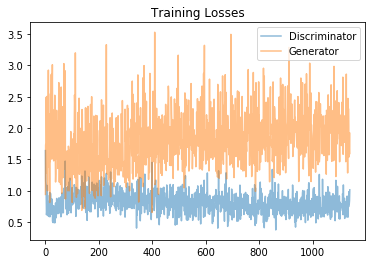

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

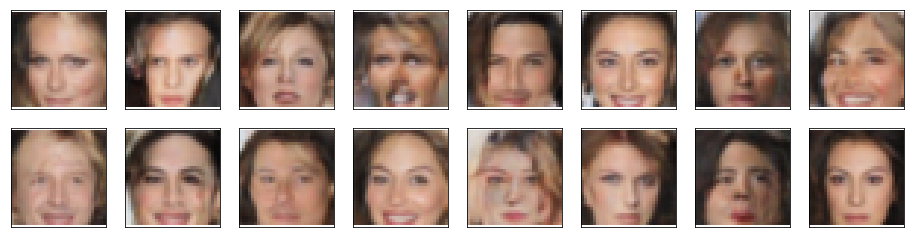

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

On this model, I have considered the suggested modifications of the last review: I decreased the batch size to 32, I increased the learning rate to 0.0006, I added dropout layers (with a drop probability of 0.1) after each convolutional of the discriminator and on the case of the generator, I added a dropout layer after each transpose convolutional layer but excepting the last one. I also added an extra convolutional transpose layer in the generator.

Once the model trained for 20 epochs, I could remark that the images created by this DCGAN look more realistic comparing with the images of my previous model. But there are some fake images that contain faces that look almost like a human face. In the current samples, all the fake images are white, this is due to the fact that the dataset is biased. 

In order to improve the model, we could do the following:

- Clean the dataset, some images contain faces wearing accessories like hats, sunglasses, or another kind of objects that perturb the model to learn features of human faces. 
- Get more images of celebrities (or normal people) from all the continents, with this will solve the problem of the biased dataset.
- Create a deeper model, this will allow to the model to learn more features in the feature space:
 - Add more convolutional and transpose convolutional layers in the discriminator and generator respectively.
 - Add more fully connected layers in the model
 - In the same line, we could also adapt the model to process/generate images with higher resolution.
- Tuning the optimizer
- Increase the number of epochs during the model training, the longer the model is trained the better will be its performance. The discriminator will become better at detecting fake data and the generator will generate data that is indistinguishable from real data. 



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.